### LIBRARIES USED

In [86]:
#%load_ext autoreload
%reload_ext autoreload
import functions_new_jit as func
import importlib

###########################################################################################################################################

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from IPython.display import clear_output
from scipy.integrate import quad

import numba

### NORMAL DISTRIBUTION CASE

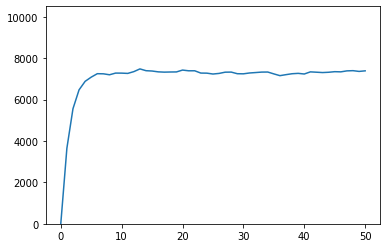

In [117]:
#system parameters
N = 10000
average = 27
deviation = 12
steps = 50
sector0_size = N
sector1_size = 0

#create agents
agents = func.create_agents_not_truncated(N,average,deviation)
agents2 = np.copy(agents)

#create system and simulate
system = func.System(agents, sector0_size, sector1_size)
progression, states = func.simulate_riot_sectors_exit_intermediary(system, steps)

#bring back the agent list
agents = agents2

plt.figure()
plt.plot(progression[0])
plt.ylim(-5,1.05*N)
plt.show()

In [125]:
k = 300
N = 10000
steps = 200
sector0_size = N
sector1_size = 0

media = 0

for i in range(k):
    #create agents
    agents = func.create_agents_not_truncated(N,average,deviation)

    #create system and simulate
    system = func.System(agents, sector0_size, sector1_size)
    progression, states = func.simulate_riot_sectors_exit_intermediary(system, steps)

    media += progression[0][-1]
    
    
print(media/k)

7300.376666666667


In [118]:
#creating arrays for data display
thresholds = np.zeros(N)

for i in range(N):
    thresholds[i] = agents[i].threshold
    
thresholds = sorted(thresholds)

min_threshold = thresholds[0]
max_threshold = thresholds[-1]
#print(min_threshold, max_threshold)

threshs = np.linspace(np.floor(min_threshold),np.floor(max_threshold),int(np.floor(max_threshold) - np.floor(min_threshold)) + 1,endpoint = True)
threshsForFloored = np.linspace(np.floor(min_threshold),np.floor(max_threshold)+1,int(np.floor(max_threshold) - np.floor(min_threshold)) + 2,endpoint = True)

"""
print(threshs)
print(threshsForFloored)
print(thresholds)
print(thresholdsFloored)
"""

thresholdsFloored = np.zeros(N)
for i in range(N):
    thresholdsFloored[i] = np.floor(thresholds[i]) 

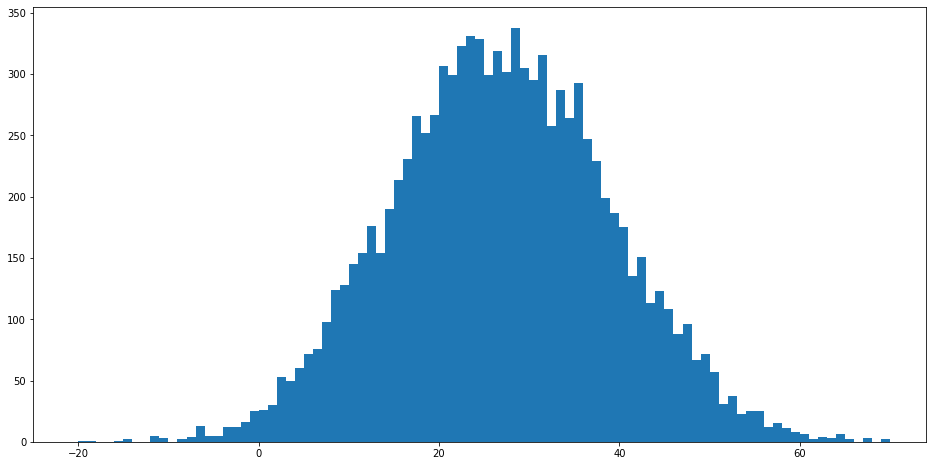

'\nplt.figure(figsize=(16,8))\nplt.hist(thresholds,threshs)\nplt.xlim(np.floor(min_threshold) - 5,np.floor(max_threshold) + 5)\nplt.show()\n'

In [119]:
#ploting the agent's threshold histogram
plt.figure(figsize=(16,8))
plt.hist(thresholdsFloored,threshsForFloored)
plt.xlim(np.floor(min_threshold) - 5,np.floor(max_threshold) + 5)
plt.show()

"""
plt.figure(figsize=(16,8))
plt.hist(thresholds,threshs)
plt.xlim(np.floor(min_threshold) - 5,np.floor(max_threshold) + 5)
plt.show()
"""

##### ANALITICAL APPROACH

In [120]:
#defining the agent's threshold distribution in the population
def fpFunction(min_threshold, max_threshold, average, deviation):
    tau = np.linspace(min_threshold,max_threshold,1000,endpoint=True)
    res = 1/(deviation * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((tau - average)*(tau - average))/(deviation*deviation))
    return res

#defining the probability of an agent entering the riot as a function of the threshold (p_e function)
def peFunction(min_threshold, max_threshold, k, m):
    tau = np.linspace(min_threshold,max_threshold,1000,endpoint=True)
    res = 1/(1 + np.exp(m * (tau/100 - k/N)))
    return res

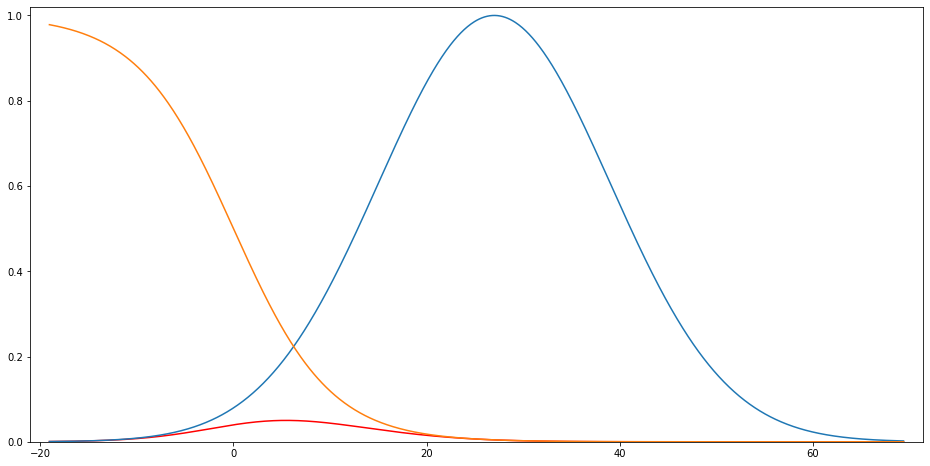

In [121]:
#plotting the distribuition of agents in the reservoir, sector and the p_e function
m = 20

tau = np.linspace(min_threshold,max_threshold,1000,endpoint=True)
f_p = fpFunction(min_threshold, max_threshold, average, deviation)
p_e = peFunction(min_threshold, max_threshold, progression[0][0], m)
f_s = np.multiply(f_p,p_e)

plt.figure(figsize=(16,8))
plt.plot(tau,f_s*(1/max(f_p)),'r')
plt.plot(tau,f_p*(1/max(f_p)))
plt.plot(tau,p_e)
plt.xlim(min_threshold - 2,max_threshold + 2)
plt.ylim(0,1.02)
plt.show()

In [122]:
#defining a function for further integration
def prevision(x, k, N, m):
    a = 1/(1 + np.exp(m * (x/100 - k/N)))
    b = 1/(deviation * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - average)*(x - average))/(deviation*deviation))
    res = a*b
    return res

In [123]:
k = 0
m = 20

tau = np.linspace(min_threshold,max_threshold, 1000, endpoint=True)
f_p = fpFunction(min_threshold, max_threshold, average, deviation)
p_e = peFunction(min_threshold, min_threshold, k, m)
f_s = np.multiply(f_p,p_e)

In [124]:
passo = 1

tau = np.linspace(min_threshold,max_threshold, 1000, endpoint=True)
f_p = fpFunction(min_threshold, max_threshold, average, deviation)

m = 2
erro = 0

for i in range(1,steps):
    if i%passo == 0:
        a = input()
        if a == "":
            p_e = peFunction(min_threshold, max_threshold, progression[0][i-1], m)
            #resultado exato
            f_s = np.multiply(f_p,p_e) 
            
            plt.figure(figsize=(16,8))
            plt.hist(thresholdsFloored,threshsForFloored)
            plt.hist(states[i][0], threshs)
            plt.plot(tau,f_p*N,'k')
            plt.plot(tau,f_s*N,'r')
            plt.xlim(min_threshold - 5,max_threshold + 5)
            plt.show()
            
            a = min_threshold
            b = max_threshold
            integral = N*quad(prevision, a, b, args=(progression[0][i-1],N,m))[0]
            erro += abs((integral - progression[0][i])/progression[0][i])
            print("Integral: " + str(integral))
            print("Progresso: " + str(progression[0][i]))
            print("Erro: " + str(abs((integral - progression[0][i])/progression[0][i]) * 100)[:4] + "%")
            clear_output(wait=True)
            if progression[0][i] == N:
                break
        elif a != "":
            break
            
print("Erro médio: " + str(erro/(steps-1) * 100)[:4] + "%")

 0


Erro médio: 0.64%


### LINEAR DISTRIBUTION CASE

In [103]:
def create_thresholds_linear(N):
    thresholds = np.zeros(N)
    for i in range(N):
        thresholds[i] = np.random.random() * 100
        
    return thresholds

def create_thresholds_linear_strong(N):
    thresholds = np.zeros(N)
    for i in range(100):
        for j in range(int(N/100)):
            thresholds[i*int(N/100) + j] = i
        
    return thresholds

def create_agents_linear(N):
    agents = numba.typed.List()
    
    thresholds = create_thresholds_linear(N)
    
    for i in range(N):
        agents.append(func.Agent(thresholds[i]))
        
    return agents

def create_agents_linear_strong(N):
    agents = numba.typed.List()
    
    thresholds = create_thresholds_linear_strong(N)
    
    for i in range(N):
        agents.append(func.Agent(thresholds[i]))
        
    return agents

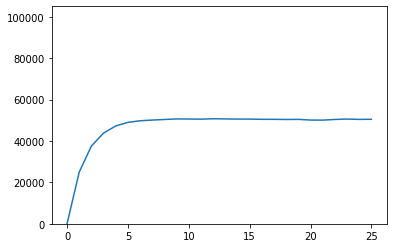

In [104]:
#system parameters
N = 100000
steps = 25
sector0_size = N
sector1_size = 0

#create agents
agents = create_agents_linear_strong(N)
agents2 = np.copy(agents)

#create system and simulate
system = func.System(agents, sector0_size, sector1_size)
progression, states = func.simulate_riot_sectors_exit_intermediary(system, steps)

#bring back the agent list
agents = agents2

plt.figure()
plt.plot(progression[0])
plt.ylim(-5,1.05*N)
plt.show()

In [114]:
k = 1000
N = 1000
steps = 200
sector0_size = N
sector1_size = 0

media = 0

for i in range(k):
    #create agents
    agents = create_agents_linear(N)

    #create system and simulate
    system = func.System(agents, sector0_size, sector1_size)
    progression, states = func.simulate_riot_sectors_exit_intermediary(system, steps)
    
    media += progression[0][-1]
    
    
print(media/k)

500.501


A média do create_agents_linear foi de cerca de 44% do valor total de agentes, já a média do create_agents_linear_strong é de cerca de 88%. 

In [105]:
#creating arrays for data display
thresholds = np.zeros(N)

for i in range(N):
    thresholds[i] = agents[i].threshold
    
thresholds = sorted(thresholds)

min_threshold = thresholds[0]
max_threshold = thresholds[-1]
#print(min_threshold, max_threshold)

threshs = np.linspace(np.floor(min_threshold),np.floor(max_threshold),int(np.floor(max_threshold) - np.floor(min_threshold)) + 1,endpoint = True)
threshsForFloored = np.linspace(np.floor(min_threshold),np.floor(max_threshold)+1,int(np.floor(max_threshold) - np.floor(min_threshold)) + 2,endpoint = True)

"""
print(threshs)
print(threshsForFloored)
print(thresholds)
print(thresholdsFloored)
"""

thresholdsFloored = np.zeros(N)
for i in range(N):
    thresholdsFloored[i] = np.floor(thresholds[i]) 

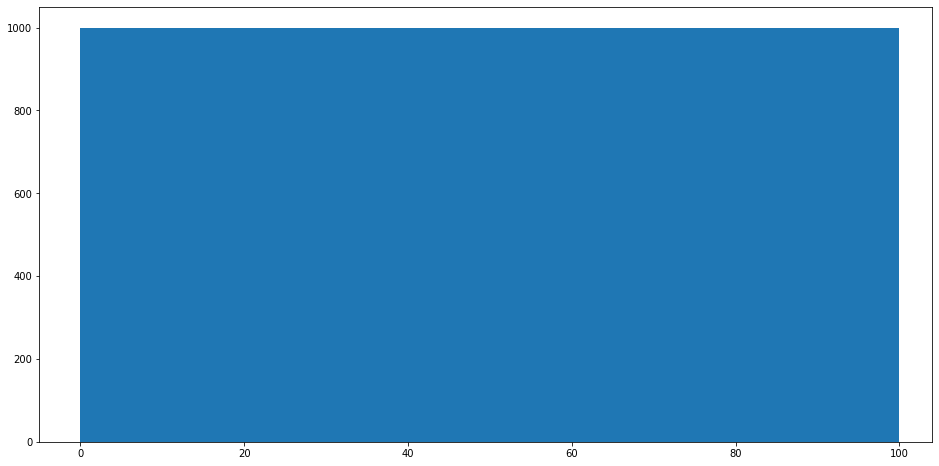

'\nplt.figure(figsize=(16,8))\nplt.hist(thresholds,threshs)\nplt.xlim(np.floor(min_threshold) - 5,np.floor(max_threshold) + 5)\nplt.show()\n'

In [106]:
#ploting the agent's threshold histogram
plt.figure(figsize=(16,8))
plt.hist(thresholdsFloored,threshsForFloored)
plt.xlim(np.floor(min_threshold) - 5,np.floor(max_threshold) + 5)
plt.show()

"""
plt.figure(figsize=(16,8))
plt.hist(thresholds,threshs)
plt.xlim(np.floor(min_threshold) - 5,np.floor(max_threshold) + 5)
plt.show()
"""

##### ANALITICAL APPROACH

In [107]:
#defining the agent's threshold distribution in the population
def fpFunction():
    res = np.full(1000,0.01)
    return res

#defining the probability of an agent entering the riot as a function of the threshold (p_e function)
def peFunction(min_threshold, max_threshold, k, m):
    tau = np.linspace(min_threshold,max_threshold,1000,endpoint=True)
    res = 1/(1 + np.exp(m * (tau/100 - k/N)))
    return res

#defining the analitical result of the distribution of agents in the sector
def fsAnalitical(max_threshold, m, i):
    tau = np.linspace(0,max_threshold/100,1000,endpoint=True)
    res = i/(i + np.exp(m*tau))
    return res

#defining the analitical result of the distribution of agents in the sector [linear approximation]
def fsAnaliticalLinear(max_threshold, N, m, i):
    tau = np.linspace(0,max_threshold/100,1000,endpoint=True)
    c = m/4
    res = 1/2 - m/4*(tau) + (m*(4-m)/32)*((np.power(c,i-1) - 1)/(c - 1))
    return res

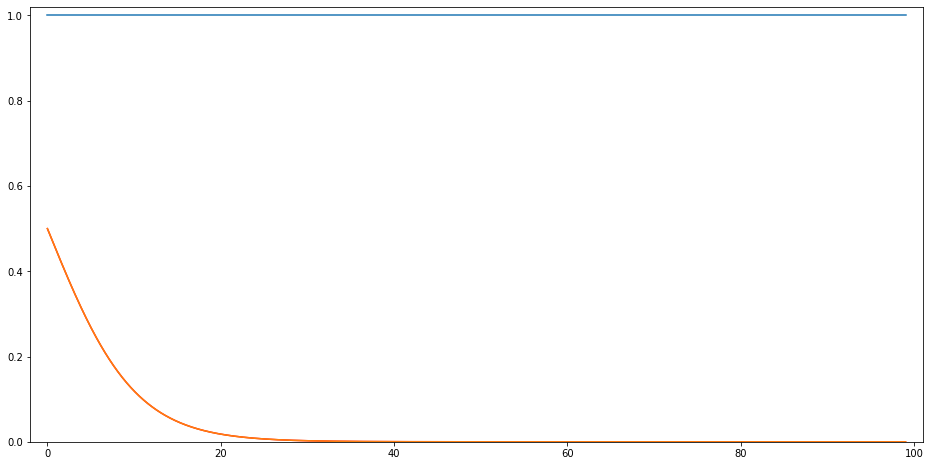

In [108]:
#plotting the distribuition of agents in the reservoir, sector and the p_e function
m = 20

tau = np.linspace(min_threshold,max_threshold,1000,endpoint=True)
f_p = fpFunction()
p_e = peFunction(min_threshold, max_threshold, progression[0][0], m)
f_s = np.multiply(f_p,p_e)

plt.figure(figsize=(16,8))
plt.plot(tau,f_s*(1/max(f_p)),'r')
plt.plot(tau,f_p*(1/max(f_p)))
plt.plot(tau,p_e)
plt.xlim(min_threshold - 2,max_threshold + 2)
plt.ylim(0,1.02)
plt.show()

In [109]:
#defining a function for further integration
def prevision(x, k, N, m):
    a = 1/(1 + np.exp(m * (x/100 - k/N)))
    b = 0.01
    res = a*b
    return res

In [110]:
passo = 1

tau = np.linspace(min_threshold,max_threshold, 1000, endpoint=True)
f_p = fpFunction()

m = 2
erro = 0

for i in range(1,steps):
    if i%passo == 0:
        a = input()
        if a == "":
            print("Passo: " + str(i))
            p_e = peFunction(min_threshold, max_threshold, progression[0][i-1], m)
            #resultado exato
            f_s = np.multiply(f_p,p_e)
            #previsao analítica
            f_s_analitical = fsAnalitical(max_threshold, m, i)
            f_s_analitical_linear = fsAnaliticalLinear(max_threshold, N, m, i)
            
            plt.figure(figsize=(16,8))
            plt.hist(thresholdsFloored,threshsForFloored)
            plt.hist(states[i][0], threshsForFloored)
            
            plt.plot(tau,f_p*N,'k', label='f_p')
            plt.plot(tau,f_s*N,'r', label='exact')
            plt.plot(tau,f_s_analitical*(N/100),'g',label='analitical')
            plt.plot(tau,f_s_analitical_linear*(N/100),'b', label='analitical linear')
            
            plt.xlim(min_threshold - 5,max_threshold + 5)
            plt.ylim(-0.05,N/100 * 1.05)
            plt.legend()
            plt.show()
            
            a = min_threshold
            b = max_threshold
            integral = N*quad(prevision, a, b, args=(progression[0][i-1],N,m))[0]
            erro += abs((integral - progression[0][i])/progression[0][i])
            print("Integral: " + str(integral))
            print("Progresso: " + str(progression[0][i]))
            print("Erro: " + str(abs((integral - progression[0][i])/progression[0][i]) * 100)[:4] + "%")
            clear_output(wait=True)
            if progression[0][i] == N:
                break
        elif a != "":
            break
            
print("Erro médio: " + str(erro/(steps-1) * 100)[:4] + "%")

 0


Erro médio: 1.25%
